## Skipgrams in Keras

- In this lecture, we will implement Skipgrams in `Keras`.

#### Loading in and preprocessing data
- Load the Alice in Wonderland data in Corpus using Keras utility
- `Keras` has some nice text preprocessing features too!
- Split the text into sentences.
- Use `Keras`' `Tokenizer` to tokenize sentences into words.

In [1]:
# Imports
# Basics
from __future__ import print_function, division
import pandas as pd 
import numpy as np
import random
from IPython.display import SVG
from scipy.spatial.distance import cosine
%matplotlib inline

import gensim
import os
# nltk
from nltk import sent_tokenize
# Compile the Keras Model
from keras.optimizers import SGD

# keras
import keras.backend
np.random.seed(13)
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Activation,Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot 
from keras.preprocessing.sequence import skipgrams

Using TensorFlow backend.


In [2]:
# We'll use Alice in Wonderland
path = os.path.join(os.getcwd(),"Alice_in_Wonderland.txt")
corpus = open(path,encoding='utf-8').read()

In [3]:
# Split document into sentences first
corpus = corpus[corpus.index('\n\n')+2:]  #remove header.
#print(corpus)

In [4]:
sentences = sent_tokenize(corpus) #has some punctuation symbols to be removed in the next step
#print(sentences)
base_filter='!"#$%&()*+,-./:;`<=>?@[\\]^_{|}~\t\n' + "'" 
tokenizer = Tokenizer(filters=base_filter)
tokenizer.fit_on_texts(sentences)

In [5]:
# Convert tokenized sentences to sequence format
sequences = tokenizer.texts_to_sequences(sentences)
nb_samples = sum(len(s) for s in corpus)
print(len(sequences), tokenizer.document_count)
print(nb_samples)

1744 1744
163738


In [6]:
# To understand what is happening;

print(sentences[324])  # this is a sentence
print(sequences[324])  # this is the same sentence where words are encoded as numbers.
# print(list(tokenizer.word_index[word.lower().replace('.', '')] for word in sentences[324].split()))

Alice guessed in a
moment that it was looking for the fan and the pair of white kid gloves,
and she very good-naturedly began hunting about for them, but they were
nowhere to be seen--everything seemed to have changed since her swim in
the pool, and the great hall, with the glass table and the little door,
had vanished completely.
[12, 1065, 11, 4, 155, 14, 6, 13, 153, 24, 1, 400, 2, 1, 700, 5, 159, 703, 373, 2, 7, 32, 181, 1987, 85, 1066, 42, 24, 49, 26, 30, 54, 1363, 3, 27, 265, 294, 179, 3, 52, 482, 848, 16, 734, 11, 1, 372, 2, 1, 137, 428, 17, 1, 391, 231, 2, 1, 35, 162, 25, 849, 1988]


#### Skipgrams: Generating Input and Output Labels
- Now that we have sentences, and word tokenization, we are in good position to create our training set for skipgrams.
- Now we need to generate our `X_train` and `y_train`

In [7]:
# Let's first see how Keras' skipgrams function works.

couples, labels = skipgrams(sequences[324], len(tokenizer.word_index) + 1,
    window_size=2, negative_samples=0, shuffle=True,
    categorical=False, sampling_table=None)

# print(couples,labels)
index_2_word = {val: key for key, val in tokenizer.word_index.items()}

for w1, w2 in couples:
    if w1 == 13:
        print(index_2_word[w1], index_2_word[w2])

was looking
was that
was for
was it


In [8]:
# Function to generate the inputs and outputs for all windows

# Vocab size
vocab_size = len(tokenizer.word_index) + 1
# Dimension to reduce to
dim = 100
window_size = 2


def generate_data(sequences, window_size, vocab_size):
    for seq in sequences:
        X, y = [], []
        couples, _ = skipgrams(
            seq, vocab_size,
            window_size=window_size, negative_samples=0, shuffle=True,
            categorical=False, sampling_table=None)
        if not couples:
            continue
        for in_word, out_word in couples:
            X.append(in_word)
            y.append(np_utils.to_categorical(out_word, vocab_size))
        X, y = np.array(X), np.array(y)
        X = X.reshape(len(X), 1)
        y = y.reshape(len(X), vocab_size)
        yield X, y
        
data_generator = generate_data(sequences, window_size, vocab_size)

### Skipgrams: Creating the Model
- Lastly, we create the (shallow) network!

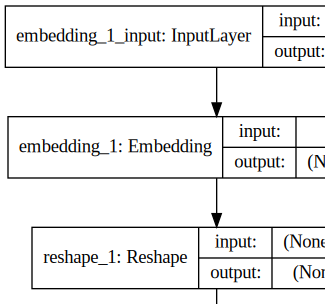

In [9]:
# Create the Keras model and view it 
skipgram = Sequential()
skipgram.add(Embedding(input_dim=vocab_size, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim,)))
skipgram.add(Dense(input_dim=dim, units=vocab_size, activation='softmax'))
SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg'))

### Skipgrams: Compiling and Training
- Time to compile and train
- We use crossentropy, common loss for classification

In [10]:

sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9)

skipgram.compile(loss='categorical_crossentropy', optimizer="adadelta")

# Fit the Skipgrams
for iteration in range(10):
    loss = 0
    for x, y in generate_data(sequences, window_size, vocab_size):
        loss += skipgram.train_on_batch(x, y)
    print('iteration {}, loss is {}'.format(iteration, loss))


iteration 0, loss is 13123.474479198456
iteration 1, loss is 11779.688267469406
iteration 2, loss is 11157.769812107086
iteration 3, loss is 10855.440164089203
iteration 4, loss is 10682.516449809074
iteration 5, loss is 10564.241443514824
iteration 6, loss is 10472.500138640404
iteration 7, loss is 10396.319508552551
iteration 8, loss is 10330.800001263618
iteration 9, loss is 10272.768285870552


### Skipgrams: Looking at the vectors

To get word_vectors now, we look at the weights of the first layer.

Let's also write functions giving us similarity of two words.

In [11]:
word_vectors = skipgram.get_weights()[0]

def get_dist(w1, w2):
    i1, i2 = tokenizer.word_index[w1], tokenizer.word_index[w2]
    v1, v2 = word_vectors[i1], word_vectors[i2]
    return cosine(v1, v2)

def get_similarity(w1, w2):
    return 1-get_dist(w1, w2)

def get_most_similar(w1, n=10):
    sims = {word: get_similarity(w1, word) 
            for word in tokenizer.word_index.keys()
            if word != w1}
    sims = pd.Series(sims)
    sims.sort_values(inplace=True, ascending=False)
    return sims.iloc[:n]


print(get_similarity('king', 'queen'))
print('')
print(get_most_similar('queen'))

0.9377803802490234

gryphon        0.957120
duchess        0.943000
king           0.937780
dormouse       0.933557
hatter         0.923912
caterpillar    0.915497
first          0.905976
cat            0.902722
white          0.900410
march          0.900139
dtype: float64


## CBOW Model

In [12]:
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=dim, input_length=window_size*2))
cbow.add(Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(dim,)))
cbow.add(Dense(vocab_size, activation='softmax')) #first input is (vocab_size,1) instead of skip gram model

In [13]:
cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [14]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, vocab_size):
        loss += cbow.train_on_batch(x, y)

    print(ite, loss)

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0


In [15]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, dim))

9

In [16]:
vectors = cbow.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

In [17]:
w2v = gensim.models.KeyedVectors.load_word2vec_format(os.path.join(os.getcwd(),"vectors.txt"),binary=True,unicode_errors='ignore')

In [18]:
w2v.most_similar(positive=['the'])

/home/amazon/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:2372: RuntimeWarning: overflow encountered in square
  dist = sqrt((m ** 2).sum(-1))[..., newaxis]


[('-0.044734515', 0.6432422399520874),
 ('843541', 0.6233307719230652),
 ('94475', 0.5990298986434937),
 ('78', 0.5961076617240906),
 ('0.016130604', 0.5802446603775024),
 ('5223', 0.5669052600860596),
 ('8586', 0.5543237328529358),
 ('127', 0.5524085760116577),
 ('045603838', 0.5436569452285767),
 ('2206', 0.5420832633972168)]